In [400]:
%%html
<style>
table {float:left}
</style>

In [401]:
# my python files
import src.analytics as tics
import src.plotting_functions as pltfuncs
import src.transforms as trans
import src.hyp_test as hyp
import src.score_model as sc
import src.roc_curve as roc


# Imports
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import kendalltau
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline)
from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)
from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [402]:
# On OSX requires brew install coreutils, using gshuf instead of shuf
sample_name = 'data/sample_random_subset.csv'
tics.create_random_samples('data/kddcup.data', 100000, sample_name)

df = trans.read_data(sample_name)

### Dropping Features


**Highly Correlated Features**

In [407]:
df = trans.drop_high_correlations(df)

#df.info()

In [411]:
trans.drop_zeros_columns(df)

# df.columns

#### Dropping irrelevant features
Considering that lasso is determining what features to keep (below), I decided to drop the suggested keepers until I get to a point where my logistic regression fails adequately.  This is an attempt to discern which features are derived

#### Then, trimming down a bit at a time

In [370]:
# create dict based on dtypes
g = df.columns.to_series().groupby(df.dtypes).groups
df_dtypes = {k.name: v for k, v in g.items()}
print(df_dtypes)

# get list of objects
objects = df_dtypes['object']
numeric = df_dtypes

{'int64': Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'dst_host_count'],
      dtype='object'), 'float64': Index(['rerror_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_diff_srv_rate', 'dst_host_srv_diff_host_rate'],
      dtype='object'), 'object': Index(['protocol_type', 'service', 'flag', 'label'], dtype='object')}


Index(['protocol_type', 'service', 'flag', 'label'], dtype='object')

In [371]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
duration                       100000 non-null int64
protocol_type                  100000 non-null object
service                        100000 non-null object
flag                           100000 non-null object
src_bytes                      100000 non-null int64
dst_bytes                      100000 non-null int64
land                           100000 non-null int64
wrong_fragment                 100000 non-null int64
hot                            100000 non-null int64
num_failed_logins              100000 non-null int64
logged_in                      100000 non-null int64
num_compromised                100000 non-null int64
root_shell                     100000 non-null int64
su_attempted                   100000 non-null int64
num_root                       100000 non-null int64
num_file_creations             100000 non-null int64
num_shells                     100000 n

In [391]:
def drop_all_except(df_, keep):
    for i in list(df.columns):
        if i != 'label' and i not in keep:
            drop_if_in(df_, i)
    return df

df2 = drop_all_except(df, objects)

    
df.info()

dropped attack_category
dropped protocol_type_icmp
dropped protocol_type_tcp
dropped protocol_type_udp
dropped service_IRC
dropped service_X11
dropped service_Z39_50
dropped service_auth
dropped service_bgp
dropped service_courier
dropped service_csnet_ns
dropped service_ctf
dropped service_daytime
dropped service_discard
dropped service_domain
dropped service_domain_u
dropped service_echo
dropped service_eco_i
dropped service_ecr_i
dropped service_efs
dropped service_exec
dropped service_finger
dropped service_ftp
dropped service_ftp_data
dropped service_gopher
dropped service_hostnames
dropped service_http
dropped service_http_443
dropped service_imap4
dropped service_iso_tsap
dropped service_klogin
dropped service_kshell
dropped service_ldap
dropped service_link
dropped service_login
dropped service_mtp
dropped service_name
dropped service_netbios_dgm
dropped service_netbios_ns
dropped service_netbios_ssn
dropped service_netstat
dropped service_nnsp
dropped service_nntp
dropped serv

In [376]:
# title = 'Correlation Matrix of data after Dropping Correlated'
# pltfuncs.corr_heat(df, title)

In [377]:
# df.columns
# g = sns.pairplot(df)

### Modeling
#### First try to get a simple logistic regression model working
- steps to get there
    - transform Label into its attack_category
    - transform attack_category into only DOS (2), the rest zero, as DOS is the most prevalent type
    - balance the data set by undersampling the more represented y

In [378]:
# read in label names csv and send it as dictionary to mapping function
label_names = ['label', 'attack_category', 'attack_cat_num']
labels_loc = 'data/categories.csv'
labels_to_categories = pd.read_csv(labels_loc, header=None)
labels_to_categories.columns = label_names
col_name = 'label'
new_col_name = 'attack_category'

df = trans.rewrite_values(df, dict(zip(labels_to_categories.label, labels_to_categories.attack_cat_num)), col_name, new_col_name)
df['attack_category'].value_counts()

2    79197
0    19951
1      831
4       21
Name: attack_category, dtype: int64

In [379]:
# rewrite all except attack_category types 2 to zero, put to new dataframe
df = trans.rewrite_category2_to_zeros(df)
df['attack_category'].value_counts()


1    79197
0    20803
Name: attack_category, dtype: int64

In [380]:
df = trans.split_to_5050(df)
df['attack_category'].value_counts()


removed 58394 rows


1    20803
0    20803
Name: attack_category, dtype: int64

In [381]:
# drop label BEFORE running get dummies on data
drop_if_in(df, 'label')
'label' in df

dropped label


False

In [382]:
if 'protocol_type' in df:
    df = pd.get_dummies(df)
df.shape

(41606, 77)

In [383]:
# Split X and Y
y = df['attack_category']
X = df.copy()

# in order to not throw errors
if 'attack_category' in X:
    X.drop(['attack_category'], axis=1, inplace=True)
if 'label' in X:
    X.drop(['label'], axis=1, inplace=True)
    
X.columns

Index(['protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp',
       'service_IRC', 'service_X11', 'service_Z39_50', 'service_auth',
       'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf',
       'service_daytime', 'service_discard', 'service_domain',
       'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i',
       'service_efs', 'service_exec', 'service_finger', 'service_ftp',
       'service_ftp_data', 'service_gopher', 'service_hostnames',
       'service_http', 'service_http_443', 'service_imap4', 'service_iso_tsap',
       'service_klogin', 'service_kshell', 'service_ldap', 'service_link',
       'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm',
       'service_netbios_ns', 'service_netbios_ssn', 'service_netstat',
       'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other',
       'service_pop_2', 'service_pop_3', 'service_printer', 'service_private',
       'service_remote_job', 'service_rje', 'serv

### Attempting logistic regression

In [384]:
# Split the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#
# y_train.sum()
# len(y_train)

In [385]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [386]:
from sklearn.linear_model import LogisticRegression

# logistic regression object
classifier = LogisticRegression(penalty='l1')

# teach classifier the correlations betw X_train and y_train
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [387]:
# Predict the Test set results
y_pred = classifier.predict(X_test) # vector giving prediction of each of the test set observations

True Positives: 4097
True Negatives: 4173
False Positives: 44
True Negatives: 8

Accuracy: 0.9937515020427782
Classification_error: 0.006248497957221821
Recall: 0.9980511571254568
Precision: 0.9893745472108186

confusion matrix
[[4173   44]
 [   8 4097]]


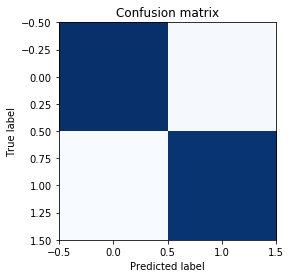

In [388]:
pltfuncs.my_confusion_matrix(y_test, y_pred)

In [389]:
lasso = Lasso()
lasso.fit(X_train, y_train)

print(lasso)
print(lasso.coef_)
# remove 0 coefficients 
lasso.coef_

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
[ 0. -0. -0. -0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.
  0.  0. -0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  0.
  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0. -0. -0.  0. -0. -0.  0. -0.
 -0. -0. -0. -0.]


array([ 0., -0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,
       -0., -0.,  0., -0., -0.,  0., -0., -0., -0., -0., -0.])

### Clean up below

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)


# scaler = StandardScaler().fit(X_train)
# X_train_1 = scaler.transform(X_train)
# X_test_1 = scaler.transform(X_test)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

# tpr, fpr, thresholds = roc.roc_curve(probabilities, y_test)
tpr, fpr, thresholds = roc_curve(y_test, probabilities, pos_label=2)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of Logistic Regression Thresholds")
plt.show()

### Attempting Lasso

In [ ]:
# scaler = StandardScaler()




scorer  = make_scorer(sc.rmsle, greater_is_better=True)

#How to manage many models
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledRidge', Pipeline([('Scaler', StandardScaler()),('EN', Ridge())])))

In [ ]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=3, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scorer)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
    plt.plot(cv_results)
#     plt.xlabel('n')
#     plt.ylabel('rmse')
#     plt.title('average test rmse vs sample size n');
    
    print(msg)

## Run classifier on test data (has new features)

## make series of pairwise plots

## plug in knn